In [1]:
# testing out CNN

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # removes the warning messages from tensorflow

In [3]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import pywt
import funcs

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')

oneHotTrain = funcs.one_hot_encoder(trainDiagnostic, 2)
oneHotValidate = funcs.one_hot_encoder(validateDiagnostic, 2)
oneHotTest = funcs.one_hot_encoder(testDiagnostic, 2)

In [6]:
# data is imbalanced so we balance it

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainDiagnostic),
                                        y = trainDiagnostic                                                    
                                    )
class_weights = dict(zip(np.unique(trainDiagnostic), class_weights))

sigmoidLoss = tf.keras.losses.BinaryCrossentropy() # one output unit
softmaxLoss = tf.keras.losses.CategoricalCrossentropy() # two output units

In [8]:
scales = np.linspace(0.1, 4, 20) # scales to use for cwt

trainTransform = funcs.make_for_cnn(trainReadings, scales, 'mexh')
validateTransform = funcs.make_for_cnn(validateReadings, scales, 'mexh')
testTransform = funcs.make_for_cnn(testReadings, scales, 'mexh')

trainTransform.shape

(10977, 1000, 20)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics, callbacks

In [10]:
inputShape = (1000, len(scales))
kernelSize = 10 #how to determine this

In [11]:
convInputLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize, input_shape=inputShape, data_format="channels_last")
convLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize)
batchNormLayer = layers.BatchNormalization(axis=1)
reLULayer = layers.ReLU()
maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize, strides=None) # should the size of the pooling layer be the same as the kernel size

In [12]:
model = Sequential()

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [22]:
metrics=['accuracy', 
         tf.keras.metrics.FalsePositives(name='false_positives'), 
         tf.keras.metrics.Precision(name='precision')]

model.compile(
    optimizer='adam', loss=softmaxLoss, 
 metrics=metrics)

In [23]:
# create a checkpoint for the best val

currentDirectory = os.getcwd()
fileName = 'best.hdf5' # model weights are stored in hdf5 file
checkpointFile = os.path.join(currentDirectory, 'ckpt', fileName)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpointFile, 
                                       save_weights_only=True, 
                                       monitor='val_precision',
                                       mode='max', #save when the val accuracy is the highest
                                       save_best_only=True, 
                                      )

In [28]:
history = model.fit(
    trainTransform, oneHotTrain, 
    epochs=100, 
    class_weight=class_weights, 
    validation_data=(validateTransform, oneHotValidate), 
    callbacks=[checkpoint])

Epoch 1/100
344/344 [==============================] - 9s 27ms/step - loss: 0.5841 - accuracy: 0.6606 - false_positives: 3726.0000 - precision: 0.6606 - val_loss: 0.4930 - val_accuracy: 0.7114 - val_false_positives: 1056.0000 - val_precision: 0.7114
Epoch 2/100
344/344 [==============================] - 9s 27ms/step - loss: 0.5575 - accuracy: 0.6755 - false_positives: 3562.0000 - precision: 0.6755 - val_loss: 0.4120 - val_accuracy: 0.7827 - val_false_positives: 795.0000 - val_precision: 0.7827
Epoch 3/100
344/344 [==============================] - 9s 26ms/step - loss: 0.5013 - accuracy: 0.7272 - false_positives: 2995.0000 - precision: 0.7272 - val_loss: 0.3662 - val_accuracy: 0.8300 - val_false_positives: 622.0000 - val_precision: 0.8300
Epoch 4/100
344/344 [==============================] - 9s 27ms/step - loss: 0.4637 - accuracy: 0.7637 - false_positives: 2594.0000 - precision: 0.7637 - val_loss: 0.5920 - val_accuracy: 0.6742 - val_false_positives: 1192.0000 - val_precision: 0.6742
Ep

Epoch 34/100
344/344 [==============================] - 9s 27ms/step - loss: 0.0957 - accuracy: 0.9595 - false_positives: 445.0000 - precision: 0.9595 - val_loss: 0.4035 - val_accuracy: 0.9237 - val_false_positives: 279.0000 - val_precision: 0.9237
Epoch 35/100
344/344 [==============================] - 9s 25ms/step - loss: 0.0886 - accuracy: 0.9659 - false_positives: 374.0000 - precision: 0.9659 - val_loss: 0.3832 - val_accuracy: 0.9150 - val_false_positives: 311.0000 - val_precision: 0.9150
Epoch 36/100
344/344 [==============================] - 9s 25ms/step - loss: 0.0534 - accuracy: 0.9754 - false_positives: 270.0000 - precision: 0.9754 - val_loss: 0.4469 - val_accuracy: 0.9218 - val_false_positives: 286.0000 - val_precision: 0.9218
Epoch 37/100
344/344 [==============================] - 10s 28ms/step - loss: 0.0724 - accuracy: 0.9674 - false_positives: 358.0000 - precision: 0.9674 - val_loss: 0.4748 - val_accuracy: 0.9218 - val_false_positives: 286.0000 - val_precision: 0.9218
Epo

Epoch 67/100
344/344 [==============================] - 9s 25ms/step - loss: 0.0899 - accuracy: 0.9686 - false_positives: 345.0000 - precision: 0.9686 - val_loss: 0.4889 - val_accuracy: 0.9276 - val_false_positives: 265.0000 - val_precision: 0.9276
Epoch 68/100
344/344 [==============================] - 8s 24ms/step - loss: 0.0286 - accuracy: 0.9884 - false_positives: 127.0000 - precision: 0.9884 - val_loss: 0.5386 - val_accuracy: 0.9306 - val_false_positives: 254.0000 - val_precision: 0.9306
Epoch 69/100
344/344 [==============================] - 8s 24ms/step - loss: 0.0201 - accuracy: 0.9931 - false_positives: 76.0000 - precision: 0.9931 - val_loss: 0.5226 - val_accuracy: 0.9259 - val_false_positives: 271.0000 - val_precision: 0.9259
Epoch 70/100
344/344 [==============================] - 8s 25ms/step - loss: 0.0355 - accuracy: 0.9862 - false_positives: 152.0000 - precision: 0.9862 - val_loss: 0.5465 - val_accuracy: 0.9322 - val_false_positives: 248.0000 - val_precision: 0.9322
Epoch

Epoch 100/100
344/344 [==============================] - 8s 25ms/step - loss: 0.0159 - accuracy: 0.9944 - false_positives: 62.0000 - precision: 0.9944 - val_loss: 0.6176 - val_accuracy: 0.9350 - val_false_positives: 238.0000 - val_precision: 0.9350


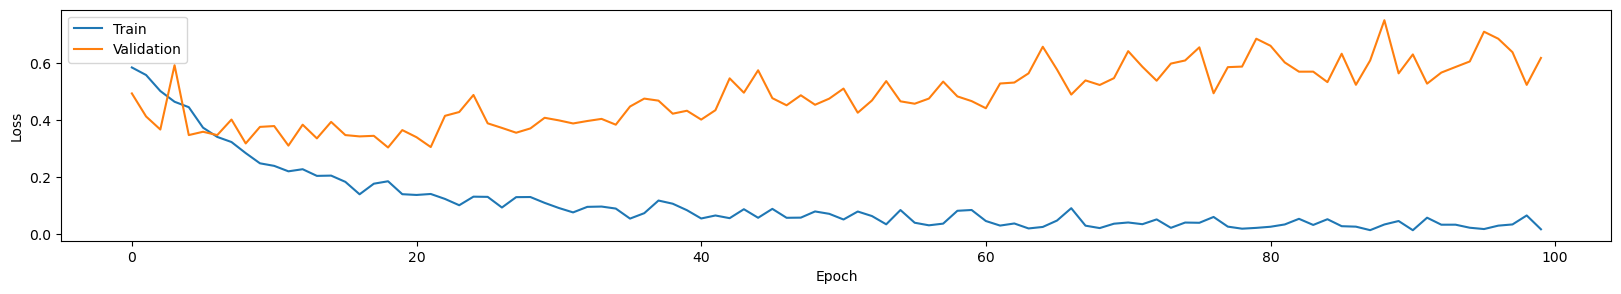

In [31]:
funcs.graph_losses(history, "Loss")

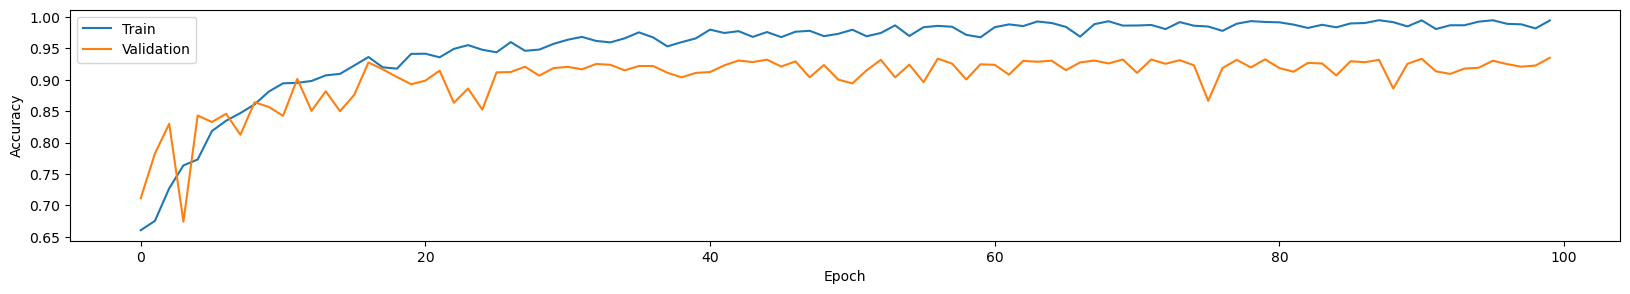

In [32]:
funcs.graph_losses(history, "Accuracy")

In [38]:
funcs.evaluate_model(model.predict(testTransform), oneHotTest)

115/115 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3353
           1       0.57      0.50      0.54       307

   micro avg       0.93      0.93      0.93      3660
   macro avg       0.76      0.73      0.75      3660
weighted avg       0.92      0.93      0.92      3660
 samples avg       0.93      0.93      0.93      3660



In [39]:
bestModel = tf.keras.models.clone_model(model)
bestModel.load_weights(checkpointFile)
funcs.evaluate_model(model.predict(validateTransform), oneHotValidate)

115/115 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3353
           1       0.65      0.49      0.56       306

   micro avg       0.93      0.93      0.93      3659
   macro avg       0.80      0.73      0.76      3659
weighted avg       0.93      0.93      0.93      3659
 samples avg       0.93      0.93      0.93      3659

